## Use DiffNet to create FEP network plan based on ML PD predictions

In [1]:
%matplotlib inline
import matplotlib

import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import numpy as np

import glob
import csv
import pandas as pd 
import pickle
import itertools
from numpy.lib.stride_tricks import as_strided

In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdFMCS, AllChem, rdmolfiles, Descriptors, rdchem, rdMolDescriptors
from rdkit.Chem.AtomPairs import Pairs

import mordred
from mordred import Calculator, descriptors

In [4]:
import sklearn
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn import metrics
from scipy import stats


# import warnings filter
from warnings import simplefilter
# ignore all future warnings (sklearn/SKOPT)
simplefilter(action='ignore', category=FutureWarning)

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from skopt import BayesSearchCV

In [5]:
import tensorflow as tf
import os
# disable GPUs:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from tensorflow import keras
from tensorflow.keras import layers

## Prepare data

In [6]:
discrete = False    # sets discretisation of SEM values.

In [7]:
quints_fps = pd.read_csv("output/quints_fps.csv", header=None)
quints_infos = pd.read_csv("output/quints_infos.csv", names=["set", "pertname", "pertsmarts", "num_ha", "sem"])

quints_whole_df = pd.concat([quints_infos, quints_fps], axis=1)

# drop faulty perturbations (n=66) that required sanitisation pre simulation. FE wrong because of atom mapping mistakes.
exclude_perts = [pert[0] for pert in pd.read_csv("to_do_sims/mapping_mismatches.csv", header=None).values.tolist()]

# extend list with inverse perts, we want to remove those as well.
inv_perts_to_exlude = []
for pert in exclude_perts:
    inv_perts_to_exlude.append(pert.split("~")[1]+"~"+pert.split("~")[0]) 
for pert in inv_perts_to_exlude:
    exclude_perts.append(pert)

quints_whole_df = quints_whole_df[~quints_whole_df['pertname'].isin(exclude_perts)]


In [8]:
# drop NaN columns (happens with molprop generation where (error) strings can't be subtracted)
quints_whole_df = quints_whole_df.dropna(axis=1)

# drop rows where SEM == 0.0. It seems some very large perturbations get this value too, so makes training noisy.
quints_whole_df = quints_whole_df[quints_whole_df["sem"] > 0.0001]

# drop columns where all values are 0.
quints_whole_df = quints_whole_df.loc[:, (quints_whole_df != 0).any(axis=0)]

# TMP DROP DUPLICATES --> should be fewer duplicates when we move up to more features.
quints_whole_df = quints_whole_df.drop_duplicates(subset=quints_whole_df.columns.difference(['sem','set','pertname','pertsmarts']))

In [9]:
if discrete:
    #DISCRETIZE BY STRATIFICATION:
    n_bins=10

    binned_sem = pd.qcut(quints_whole_df["sem"], n_bins, labels=False)
    bin_means = []
    quints_whole_df["sem_bin"] = binned_sem
    print("Bin, Min, Max, Volume")
    for n_bin, df_group in quints_whole_df.groupby(by="sem_bin"):
        print(n_bin, round(min(df_group["sem"].values), 2), round(max(df_group["sem"].values), 2), len(df_group))
        bin_means.append(np.mean(df_group["sem"].values))

In [10]:
# if we have discretised SEMS:
if discrete:
    quints_fps = quints_whole_df.drop(["set", "pertname", "pertsmarts", "num_ha", "sem", "sem_bin"], axis=1)
    quints_fps = quints_fps.values
    quints_infos = quints_whole_df[["set", "pertname", "pertsmarts", "num_ha", "sem", "sem_bin"]]
# if we have continuous SEMS:
else:
    quints_fps = quints_whole_df.drop(["set", "pertname", "pertsmarts", "num_ha", "sem"], axis=1)
    quints_fps = quints_fps.values
    quints_infos = quints_whole_df[["set", "pertname", "pertsmarts", "num_ha", "sem"]]

In [11]:
def takeSubset(indices, quints_whole_df):
    """Take a selection of a dataframe using indices"""
    subset = quints_whole_df.iloc[indices]
    
    return subset

def takeInfo(perts_df):
    """from an input dataframe, return arrays of fingerprints and SEMs"""
    try:
        sems = perts_df[["sem_bin", "sem"]].values
        # fps is a bit more involved. Remove everything but the FP columns, return as 2d array.
        fps_df = perts_df.drop(["set", "pertname", "pertsmarts", "num_ha", "sem", "sem_bin"], axis=1)
    except KeyError:
        sems = perts_df[["sem"]].values
        fps_df = perts_df.drop(["set", "pertname", "pertsmarts", "num_ha", "sem"], axis=1)
        
    fps = fps_df.values

    return fps, sems, fps_df.columns.values

In [12]:
def preProcessSet(train):
    """standardises and reduces dimensionality to 95% VE; returns arrays"""
    
    #### fit the scaler on training set.
    scaler = preprocessing.StandardScaler()
    train_scaled = scaler.fit_transform(train)
    
   
    #### fit PCA on training set with 95% variance explained.
    pca = PCA(n_components=0.95)
    train_preprocessed = pca.fit_transform(train_scaled)
    
    
    return train_preprocessed, scaler, pca

In [13]:
# grab our datasets.
whole_set, whole_set_sems, column_indices_to_keep = takeInfo(takeSubset(np.array(range(len(quints_whole_df))), quints_whole_df))

# preprocess.
whole_set, scaler, pca = preProcessSet(whole_set)

train_set = whole_set
train_sems = whole_set_sems

# save scaler and pca so that we can apply to test set.
pickle.dump(scaler, open("output/models/scaler.pkl", 'wb'))
pickle.dump(pca, open("output/models/pca.pkl", 'wb'))

if discrete:
    # adjust label arrays such that we train on classes, but keep the actual SEM values for later.
    train_sems_values = train_sems[:,1]
    train_sems = train_sems[:,0]

    upper_test_sems_values = upper_test_sems[:,1]
    upper_test_sems = upper_test_sems[:,0]

    n_classes = len(set(train_sems))

## Train DNN model ensemble using Bayes hyperparameter search CV

In [14]:
def build_model(loss='mean_squared_error', 
                lr=1e-3, 
                num_neurons_1=10,
                num_neurons_2=None,
                num_neurons_3=None,
                num_neurons_4=None,
                input_shape=train_set.shape[1],
                act="relu",
                optimizer="adam"):
    # standard setup FF DNN with input shape of input data.
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape))
    
    model.add(keras.layers.Dropout(0.4))
    # first layer.
    model.add(keras.layers.Dense(num_neurons_1, activation=act))
    model.add(keras.layers.Dropout(0.4))
    
    # second layer.
    if num_neurons_2:
        model.add(keras.layers.Dense(num_neurons_2, activation=act))
        model.add(keras.layers.Dropout(0.4))
    
    # third layer.
    if num_neurons_3:
        model.add(keras.layers.Dense(num_neurons_3, activation=act))
        model.add(keras.layers.Dropout(0.4))
        
    # fourth layer.
    if num_neurons_4:
        model.add(keras.layers.Dense(num_neurons_4, activation=act))
        model.add(keras.layers.Dropout(0.4))
    
    # standard last linear layer for regression.
    model.add(keras.layers.Dense(1, activation="linear"))
    
    # standard last layer for classification.
    #model.add(keras.layers.Dense(n_classes, activation="softmax"))
    
    if loss == "log_cosh":
        loss = tf.keras.losses.LogCosh(reduction="auto", name="log_cosh")
    model.compile(loss=loss, optimizer=optimizer, metrics=["mae"])
    return model

Scoring Bayesian Hyperparameter optimisation can be set to any of:
['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted']

### Do a cross-validated Bayesian hyperparameter search to find hyperparams

In [15]:
# shuffle dataset.
train_set, train_sems = shuffle(train_set, train_sems)

# build a keras regressor object over which to iterate.
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model, epochs=1000, verbose=0, batch_size=64)

# set hyperparameter ranges.
params_distrib = {
    "loss": ['mean_squared_error', 'mean_absolute_error', 'log_cosh', 'huber_loss', 'cosine_similarity'],
    "lr": [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    "num_neurons_1": [5, 10, 20, 40, 60, 80, 100, 120],
    "num_neurons_2": [None, 8, 20, 40, 80, 120, 140],
    "num_neurons_3": [None, 8, 20, 40, 80, 120, 140],
    "num_neurons_4": [None, 8, 20, 40, 80, 120, 140],
    "act": ["relu", "tanh", "sigmoid", "linear"],
    "optimizer": ["adam", "SGD"]
}

# use SKOPT to do Bayesian hyperparameter search with cross-validation.
hp_search_cv = BayesSearchCV(keras_reg, params_distrib, scoring="r2",
                              n_iter=100, n_jobs=8, cv=8, verbose=0)

# print out R2 on train set.
hp_result = hp_search_cv.fit(train_set, train_sems)
print(hp_result.best_params_)


/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has

/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has

OrderedDict([('act', 'tanh'), ('loss', 'mean_squared_error'), ('lr', 1e-06), ('num_neurons_1', 60), ('num_neurons_2', 80), ('num_neurons_3', 80), ('num_neurons_4', 40), ('optimizer', 'SGD')])


### Use optimal hyperparameters to fit training set

In [16]:
def plot_performance(history, model, test_set, test_sems):
    """plots keras-style model fit history and test predictions with density."""
    f, axes = plt.subplots(1,2, figsize=(13,5))
    
    # plot loss plot on left-hand side.
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title('Model loss')
    axes[0].set_ylabel('Loss (MUE of SEM)')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'])
    
    # plot scatterplot of test predictions on right-hand side.   
    model_preds = model.predict(test_set)
    # rescale model predictions to training set label range. Values can be weird depending on model output type.
    model_preds = np.interp(model_preds, (model_preds.min(), model_preds.max()), 
                                        (test_sems.min(), test_sems.max()))
    
#     print(model_preds)
    
#     # Calculate the point density
#     xy = np.vstack([test_sems, model_preds])

#     z = stats.gaussian_kde(xy)(xy)

#     axes[1].scatter(test_sems, model_preds, c=z, s=100, edgecolor=None)

    axes[1].scatter(test_sems, model_preds)
    axes[1].set_title('Test predictions')
    axes[1].set_xlabel("True SEM / kcal$\cdot$mol$^{-1}$")
    axes[1].set_ylabel("Predicted SEM / kcal$\cdot$mol$^{-1}$")
    axes[1].annotate("R2 : "+str(round(r2_score(test_sems, model_preds), 2)), 
                               xy=(1.05,0.8), xycoords="axes fraction", size=20)
    axes[1].annotate("MUE: "+str(round(mean_absolute_error(test_sems, model_preds), 2)), 
                               xy=(1.05,0.6), xycoords="axes fraction", size=20)
    axes[1].annotate("Tau: "+str(round(stats.kendalltau(test_sems, model_preds)[0], 2)), 
                               xy=(1.05,0.4), xycoords="axes fraction", size=20)
    
    plt.show()

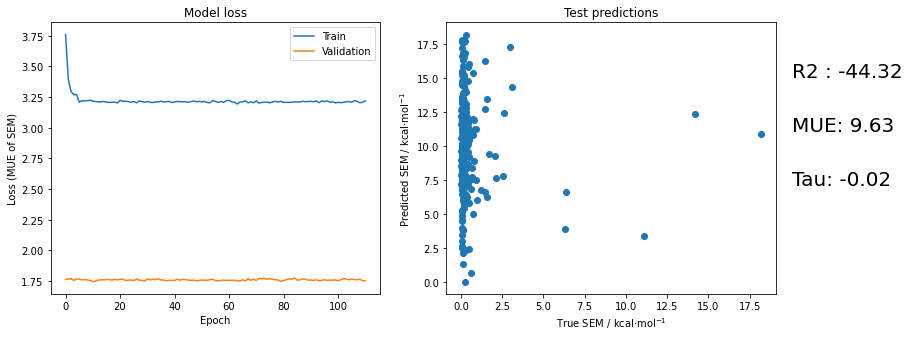

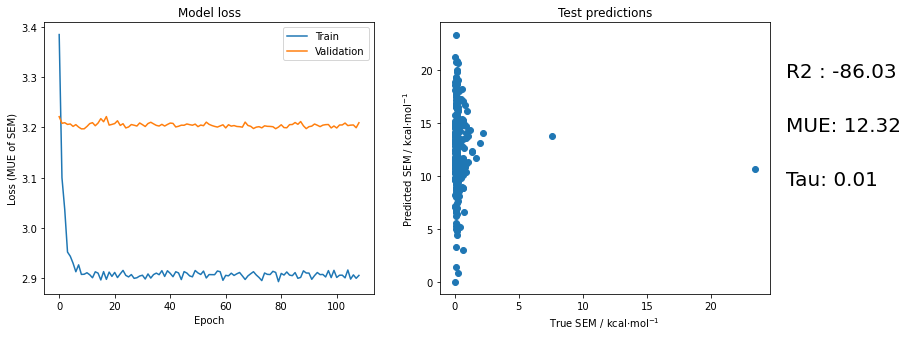

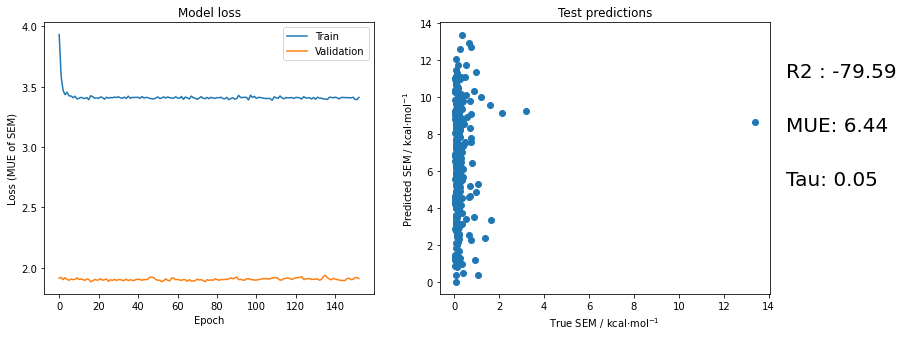

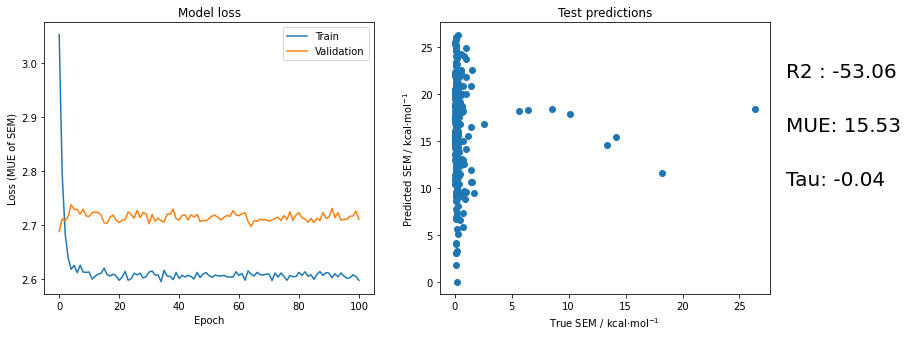

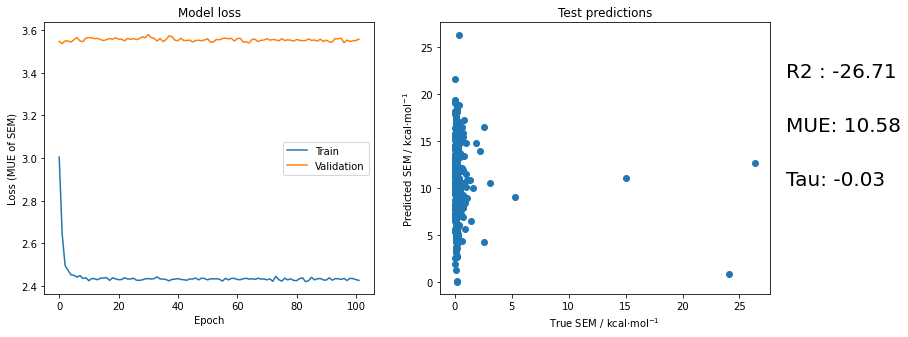

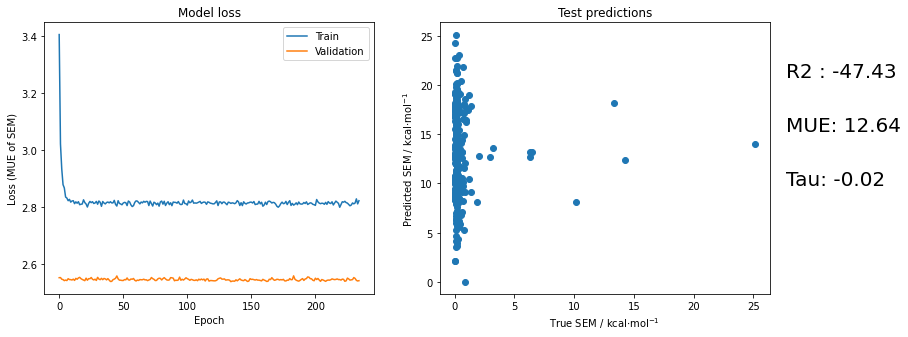

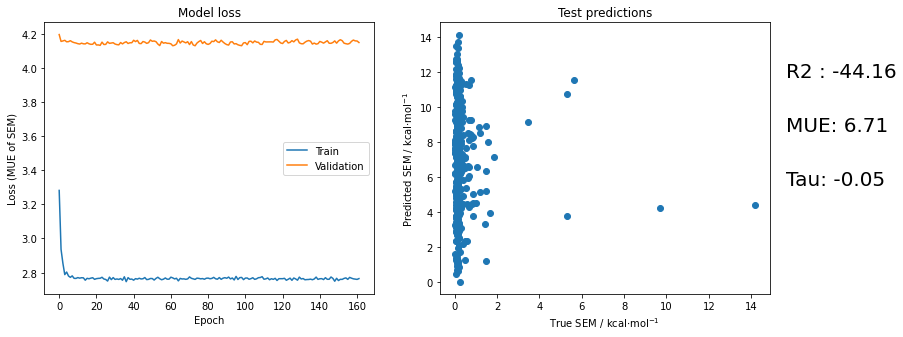

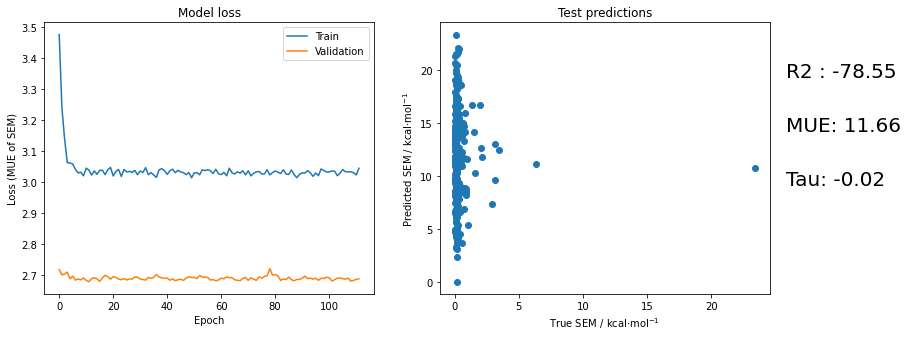

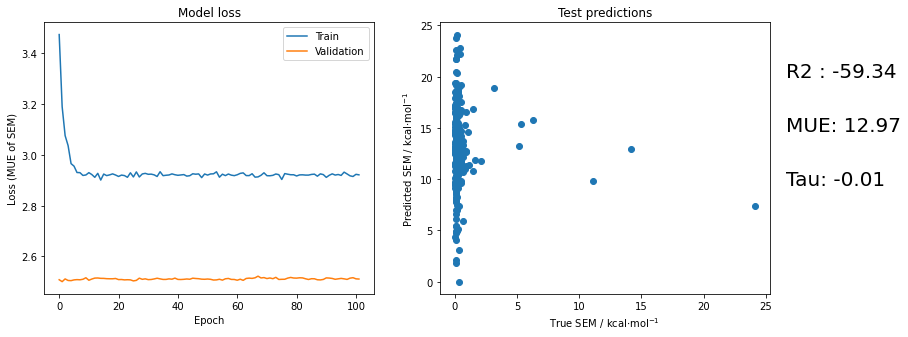

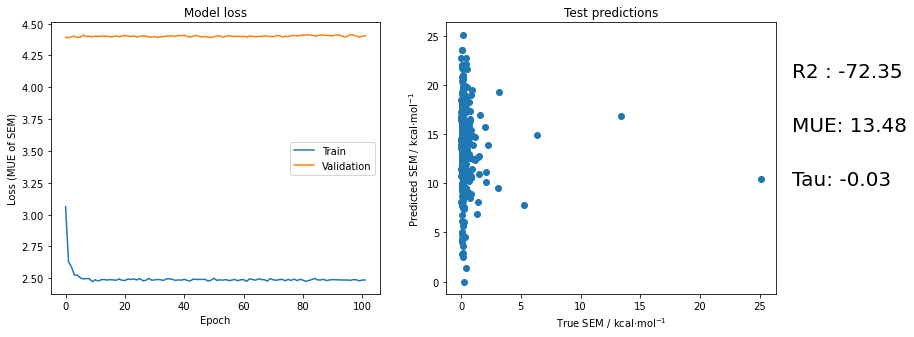

In [17]:
X = train_set
y = train_sems

for i in range(10):
    
    # leave out n% of training set to test on.
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

    # include early stopping to reduce overfitting.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=100, verbose=0,
        mode='auto', baseline=None, restore_best_weights=True
    )

    # train model.
    model = build_model(**hp_result.best_params_)
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=2000, 
                        batch_size=42, 
                        callbacks=[early_stopping], 
                        verbose=0)

    # plot loss while predicting on test set; plot this is as well.
    plot_performance(history, model, X_test, y_test)
    
    # save model for later testing.
    model.save("output/models/loeffler18_dnn_{}.h5".format(i))
   

### Load Loeffler18 set and featurise

In [18]:
mols = [ rdmolfiles.MolFromPDBFile(mol) for mol in glob.glob("TESTSETS/loeffler18/LIGANDS/*") ]
# sanitise.
for mol in mols: 
    Chem.SanitizeMol(mol)
mol_names = [ molpath.split("/")[-1].split(".pdb")[0] for molpath in glob.glob("TESTSETS/loeffler18/LIGANDS/*") ]

In [19]:
# load scaler and pca from trainingset protocol.
scaler = pickle.load(open("output/models/scaler.pkl", 'rb'))
pca = pickle.load(open("output/models/pca.pkl", 'rb'))

In [20]:
# get the featuriser.
descriptors_raw = open("./used_descriptors.txt", "r")
descriptors_raw_list = [line.split("\n") for line in descriptors_raw.readlines()]
descriptors_list = [desc[0] for desc in descriptors_raw_list]

calc = Calculator(descriptors, ignore_3D=False)  # register all descriptors
calc.descriptors = [d for d in calc.descriptors if str(d) in descriptors_list]  # re-register subset of descriptors


In [21]:
# compute features for each molecule in the list.
molprops_per_lig = [ np.array(calc(mol)) for mol in mols ]
molprops_per_lig_d = dict(zip(mol_names, molprops_per_lig))

In [22]:
# load all trained models.
models = []
for model_path in glob.glob("output/models/loeffler18_dnn_*.h5"):
    #tensorflow:
    models.append(keras.models.load_model(model_path))
    
    #sklearn:
    #models.append(pickle.load(open(model_path, 'rb')))

In [23]:
# make all possible perturbations (i.e. combinations).
preds = []
for liga, ligb in tqdm(list(itertools.combinations(mol_names, 2))):
    
    
    
    # compute features.
    pert = liga+"~"+ligb    

    dFP = []
    for lig1_prop, lig2_prop in zip(molprops_per_lig_d[liga], molprops_per_lig_d[ligb]):
        try:
            dFP.append(lig2_prop - lig1_prop)
        except TypeError:
            # when NaN, just append 0, i.e. no change.
            dFP.append(0)
    # multiple columns were excluded from our training set data, mostly null and NaN columns. Remove the 
    # same columns from this test point.

    dFP_clean = np.array(dFP)[column_indices_to_keep.astype(int)]
        
    # when NaN, just append 0, i.e. no change.
    dFP_clean = np.nan_to_num(dFP_clean)

    dFP_scaled = scaler.transform(dFP_clean.reshape(1, -1))
    dFP_prepped = pca.transform(dFP_scaled)
   
    
    # now make SEM predictions by the ensemble.
    model_preds = None
    if discrete:
        model_preds = np.zeros(shape=(1, n_classes))
        
        for model in models:
            model_preds += model.predict(dFP_prepped)
            # or .predict_proba() 
    # if using continuous SEMS:    
    else:
        model_preds = []
    
        for model in models:
            model_preds.append(float(model.predict(dFP_prepped)))
        
        
    # take ensemble average. Could return confidence here too in some way.
    preds.append(np.mean(model_preds))
    
    # when using predict_proba():
    #preds.append(np.argmax(model_preds))


In [24]:
# make an empty dataframe.
pred_mtx = pd.DataFrame(columns=mol_names, index=mol_names)

for pred, (liga, ligb) in zip(preds, list(itertools.combinations(mol_names, 2))):
    
    # add value to all predictions such that we don't end up with zeroes in matrix (breaks CVXOPT)
    #pred += 1
    
    # need to make extra sure at this step that we're not making diffnet optimize the wrong way 
    #(i.e. give edge priority to more difficult edges)!

    # fill matrix with predicted SEMs.
    pred_mtx.loc[[liga], [ligb]] = pred
    pred_mtx.loc[[ligb], [liga]] = pred
pred_mtx = pred_mtx.replace(np.nan, np.inf)
pred_mtx       

,toluene,2-methylindole,ethane,2-cyclopentanylindole,methanol,7-cyclopentanylindole,ethanol,methane,2-methylfuran,neopentane
toluene,inf,0.439272,0.380580,0.452700,0.396628,0.450442,0.401894,0.386851,0.429099,0.416759
2-methylindole,0.439272,inf,0.393710,0.443786,0.397018,0.441040,0.399735,0.395043,0.392868,0.380117
ethane,0.380580,0.393710,inf,0.409045,0.399431,0.408576,0.415283,0.406911,0.423208,0.396382
2-cyclopentanylindole,0.452700,0.443786,0.409045,inf,0.367118,0.439272,0.371018,0.375214,0.362796,0.381166
methanol,0.396628,0.397018,0.399431,0.367118,inf,0.406950,0.411457,0.395513,0.429382,0.411999
7-cyclopentanylindole,0.450442,0.441040,0.408576,0.439272,0.406950,inf,0.373567,0.375375,0.361490,0.382054
ethanol,0.401894,0.399735,0.415283,0.371018,0.411457,0.373567,inf,0.403597,0.428080,0.407085
methane,0.386851,0.395043,0.406911,0.375214,0.395513,0.375375,0.403597,inf,0.420163,0.394597
2-methylfuran,0.429099,0.392868,0.423208,0.362796,0.429382,0.361490,0.428080,0.420163,inf,0.352207
neopentane,0.416759,0.380117,0.396382,0.381166,0.411999,0.382054,0.407085,0.394597,0.352207,inf


### Write numpy matrix for Loeffler18 set, run DiffNet

In [25]:
# write predicted matrix to file.
sij = np.array(pred_mtx)
np.save("output/diffnet/loeffler18_rf_pred.npy", sij)

# write ligand order to file. This tells DiffNet which ligands are at which col/row in sij.
with open("TESTSETS/loeffler18/work/mol_imgs/ligand_index.csv", "w") as orderfile:
    writer = csv.writer(orderfile)
    for row in pred_mtx.columns:
        writer.writerow([row])

In [26]:
%%bash
# run diffnet with python2.
/home/jscheen/miniconda3/envs/DiffNet2/bin/python2.7 run_diffnet.py \
            -matrix output/diffnet/loeffler18_rf_pred.npy \
            -lig_img_path TESTSETS/loeffler18/work/mol_imgs/ \
            -lig_order_path TESTSETS/loeffler18/work/mol_imgs/ligand_index.csv \
            -ntwkpath output/diffnet/loeffler18_rf_ntwk.png

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.0000e+02  1e+03  7e-01  3e+02  1e+00
 1:  5.9392e+00  3.3658e+00  4e+01  2e-02  7e+00  2e-02
 2:  3.2090e+00  1.8600e+00  2e+01  9e-03  4e+00  3e-02
 3:  1.2876e+00  9.3658e-01  7e+00  2e-03  1e+00  2e-02
 4:  8.5910e-01  5.8226e-01  7e+00  2e-03  8e-01  2e-02
 5:  7.8284e-01  5.9627e-01  5e+00  1e-03  5e-01  2e-02
 6:  5.8619e-01  5.4087e-01  1e+00  3e-04  1e-01  6e-03
 7:  3.8039e-01  3.3858e-01  2e+00  3e-04  1e-01  8e-03
 8:  3.8430e-01  3.6119e-01  1e+00  2e-04  8e-02  6e-03
 9:  2.9536e-01  2.8866e-01  5e-01  6e-05  3e-02  3e-03
10:  2.2433e-01  2.1970e-01  7e-01  5e-05  2e-02  3e-03
11:  2.0917e-01  2.0664e-01  5e-01  3e-05  1e-02  3e-03
12:  1.6623e-01  1.6616e-01  2e-01  8e-06  3e-03  1e-03
13:  1.3639e-01  1.3684e-01  2e-01  6e-06  3e-03  1e-03
14:  1.3260e-01  1.3279e-01  9e-02  2e-06  8e-04  5e-04
15:  1.2047e-01  1.2068e-01  5e-02  7e-07  3e-04  3e-04
16:  1.1284e-01  1.1305e-01  5e-02  4e-07  2e-04  

### Plot DiffNet graph

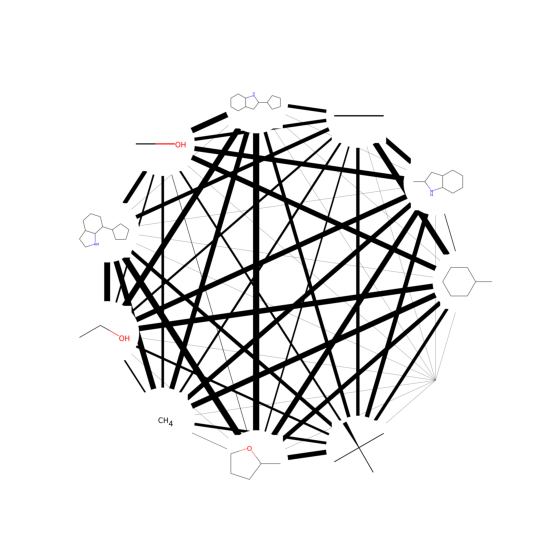

In [27]:
# load network image back into notebook.
img = mpimg.imread("output/diffnet/loeffler18_rf_ntwk.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)